In [60]:
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [42]:
batch_size = 32
img_height = 400
img_width = 400
split_ratio = 0.2

In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('animal151',
                                                               validation_split=split_ratio,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size
                                                              )

val_ds = tf.keras.preprocessing.image_dataset_from_directory('animal151',
                                                             validation_split=split_ratio,
                                                             subset="validation",
                                                             seed=123,
                                                             image_size=(img_height, img_width),
                                                             batch_size=batch_size
                                                            )
num_classes = len(train_ds.class_names)

epochs = 10

Found 6270 files belonging to 151 classes.
Using 5016 files for training.
Found 6270 files belonging to 151 classes.
Using 1254 files for validation.


### EfficientNetB0

In [44]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,
                                                              )
base_model.trainable = False

inputs = layers.Input(shape = (img_height,img_width,3), name='inputLayer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name='poolingLayer')(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(num_classes, name='outputLayer')(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

model = tf.keras.Model(inputs, outputs, name = "EfficientNetB0")

In [45]:
model.summary()

Model: "EfficientNetB0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 400, 400, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
poolingLayer (GlobalAverageP (None, 1280)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
outputLayer (Dense)          (None, 151)            

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
metric = 'val_accuracy'
check_point = K.callbacks.ModelCheckpoint(filepath="saved_model/test.h5",
                                          monitor=metric,
                                          mode="max",
                                          save_best_only=True,
                                          )

In [48]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    verbose = 1,
                    callbacks = check_point
                    )

Epoch 1/10
157/157 [==============================] - 59s 341ms/step - loss: 4.0057 - accuracy: 0.2441 - val_loss: 1.3674 - val_accuracy: 0.8389
Epoch 2/10
157/157 [==============================] - 51s 324ms/step - loss: 0.6234 - accuracy: 0.8247 - val_loss: 0.4931 - val_accuracy: 0.8955
Epoch 3/10
157/157 [==============================] - 52s 326ms/step - loss: 0.3083 - accuracy: 0.9120 - val_loss: 0.3961 - val_accuracy: 0.8971
Epoch 4/10
157/157 [==============================] - 52s 327ms/step - loss: 0.2092 - accuracy: 0.9385 - val_loss: 0.3685 - val_accuracy: 0.9067
Epoch 5/10
157/157 [==============================] - 52s 326ms/step - loss: 0.1493 - accuracy: 0.9616 - val_loss: 0.3663 - val_accuracy: 0.9115
Epoch 6/10
157/157 [==============================] - 52s 326ms/step - loss: 0.1077 - accuracy: 0.9668 - val_loss: 0.3506 - val_accuracy: 0.9123
Epoch 7/10
157/157 [==============================] - 51s 325ms/step - loss: 0.0799 - accuracy: 0.9790 - val_loss: 0.3449 - val_ac

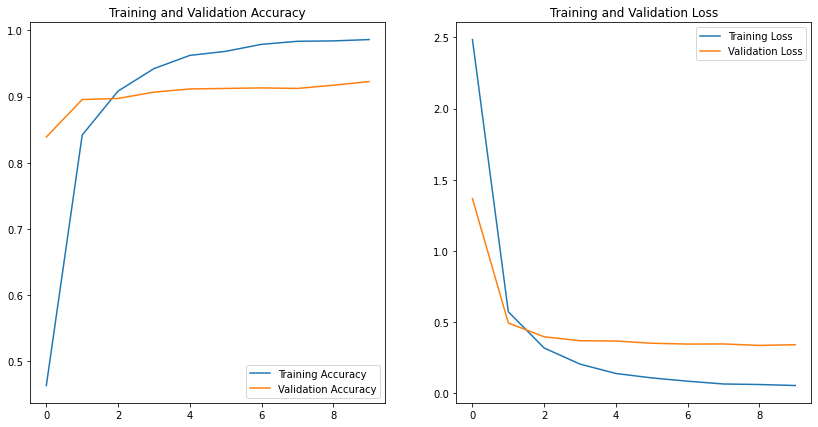

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
model = tf.keras.models.load_model('saved_model/test.h5')
score = model.evaluate(val_ds,verbose =1 )
print('Test loss:', score[0])
print('Test accuracy:', score[1])

40/40 [==============================] - 12s 243ms/step - loss: 0.3404 - accuracy: 0.9226
Test loss: 0.3403540253639221
Test accuracy: 0.9226475358009338


In [61]:
img = tf.keras.preprocessing.image.load_img(
    'predictImg/agkistrodon-contortrix.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_ds.class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to agkistrodon-contortrix with a 1.67 percent confidence.


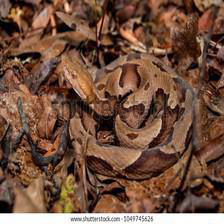

In [64]:
oriImg = tf.keras.preprocessing.image.load_img('predictImg/agkistrodon-contortrix.jpg')
oriImg.show()

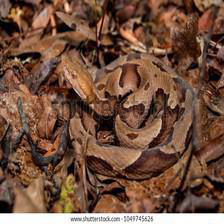

Predicted Class:agkistrodon-contortrix
Actual Class   :agkistrodon-contortrix


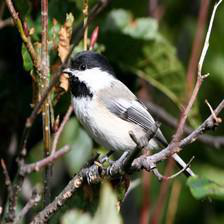

Predicted Class:poecile-atricapillus
Actual Class   :poecile-atricapillus


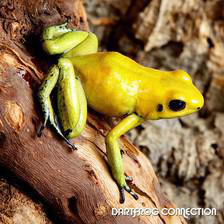

Predicted Class:phyllobates-terribilis
Actual Class   :phyllobates-terribilis


In [94]:
import os
for animal in os.listdir('predictImg'):
    img = tf.keras.preprocessing.image.load_img('predictImg/' + animal, 
                                                target_size=(img_height, img_width)
                                               )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    oriImg = tf.keras.preprocessing.image.load_img('predictImg/' + animal)
    oriImg.show()                                               
    print("Predicted Class:"+(train_ds.class_names[np.argmax(score)]))
    print('Actual Class   :' + os.path.splitext(animal)[0])